In [1]:

import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

dftrain = pd.read_csv('./data/txTripletsCounts.txt',
                      header=None,
                      index_col=None,
                      sep=' ',
                      names=['sender','receiver','transaction'])

dftest = pd.read_csv('./data/testTriplets.txt',
                     header=None,
                     index_col=None,
                     sep=' ',
                     names=['sender','receiver','transaction'])
dim = max((dftrain['sender'].max(),
           dftrain['receiver'].max(),
           dftest['sender'].max(),
           dftest['receiver'].max()))

dim += 1
train_csr = csr_matrix((dftrain['transaction'],(dftrain['sender'],dftrain['receiver'])),
                       shape=(dim,dim),
                       dtype=float)

# binarize matrix
train_csr[train_csr != 0] = 1

In [7]:
import time

t1 = time.time()
for i in range(100):
    train_csr[0, :].dot(train_csr.transpose())

t2 = time.time()
print("Time: %.2f sec" % (t2 - t1))

Time: 8.34 sec


In [12]:
def score():
    pass


def sort_row_by_similarity(train_csr, sender_id):
    #dists = train_csr.dot(train_csr[sender_id, :].transpose()).toarray()
    dists = train_csr[sender_id, :].dot(train_csr.transpose()).toarray()[0]
    # dists = np.array(dists) / np.sqrt(np.array(train_csr.sum(axis=0)))
    dist_info = [(idx, d) for (idx, d) in enumerate(dists)]
    dist_info = sorted(dist_info, key=lambda x: x[1], reverse=True)
    loc_info = [x[0] for x in dist_info]
    return loc_info


def average_top_k_similar_row(train_csr, loc_info):
    vsum = train_csr[loc_info[0], :]
    for i in range(1, len(loc_info)):
        vsum += train_csr[loc_info[i], :]
        
    vsum = vsum / len(loc_info)
    #print type(vsum)
    #print vsum
    return vsum
    

def predict_one_row(train_csr, sid):
    loc_info = sort_row_by_similarity(train_csr, sid)
    pred_mean = average_top_k_similar_row(train_csr, loc_info[:10])
    return pred_mean


def predict_by_sender_similarity(train_csr, dfpred):
    sender_ids = dfpred.sender.unique()
    pred_info = {}
    for idx, sid in enumerate(sender_ids):
        if idx % 20 == 0:
            print("[%d/%d]Working on sender: %d" % (idx, len(sender_ids), sid))
        pred_info[sid] = predict_one_row(train_csr, sid)

    for idx in range(len(dfpred)):
        sid = dfpred.loc[idx].sender
        rid = dfpred.loc[idx].receiver
        if sid not in pred_info:
            continue
        #print(sid, rid)
        #print(pred_info[sid][0, rid])
        v = pred_info[sid][0, rid]
        if v > 1 or v < 0:
            raise ValueError("prediciton value out of range: %f" % v)
        #if v != 0:
        #    print sid, rid, v
        dfpred.loc[idx, "transaction"] = v
        
    return dfpred


def predict_by_receiver_similiarity(train_csr, dfpred):
    train_csr = train_csr.transpose()
    receiver_ids = dfpred.receiver.unique()
    pred_info = {}
    for idx, rid in enumerate(receiver_ids):
        if idx % 10 == 0:
            print("[%d/%d]Working on receiver: %d" % (idx, len(receiver_ids), rid))
        pred_info[rid] = predict_one_row(train_csr, rid)
        
    for idx in range(len(dfpred)):
        sid = dfpred.loc[idx].sender
        rid = dfpred.loc[idx].receiver
        if rid not in pred_info:
            continue
        #print(sid, rid)
        #print(pred_info[sid][0, rid])
        v = pred_info[rid][0, sid]
        if v > 1 or v < 0:
            raise ValueError("prediciton value out of range: %f" % v)
        #if v != 0:
        #    print sid, rid, v
        dfpred.loc[idx, "transaction"] = v
        
    return dfpred

In [55]:
train_csr_2 = train_csr.transpose()
# print sort_row_by_similarity(train_csr_2, 1000)[:20]
# print sort_row_by_similarity(train_csr, 1000)[:20]
# print predict_one_row(train_csr_2, 1)
# print predict_one_row(train_csr, 1)

[0/1000]Working on receiver: 16
[10/1000]Working on receiver: 368648
[20/1000]Working on receiver: 153099
[30/1000]Working on receiver: 18165
[40/1000]Working on receiver: 487
[50/1000]Working on receiver: 430853
[60/1000]Working on receiver: 47263
[70/1000]Working on receiver: 1940
[80/1000]Working on receiver: 213960
[90/1000]Working on receiver: 117754
[100/1000]Working on receiver: 63778
[110/1000]Working on receiver: 353997
[120/1000]Working on receiver: 13223
[130/1000]Working on receiver: 20446
[140/1000]Working on receiver: 373134
[150/1000]Working on receiver: 4064
[160/1000]Working on receiver: 154528
[170/1000]Working on receiver: 31327
[180/1000]Working on receiver: 238787
[190/1000]Working on receiver: 390512
[200/1000]Working on receiver: 313437
[210/1000]Working on receiver: 51602
[220/1000]Working on receiver: 1105
[230/1000]Working on receiver: 201105
[240/1000]Working on receiver: 14089
[250/1000]Working on receiver: 110138
[260/1000]Working on receiver: 62599
[270/10

/Users/wenjie/anaconda/lib/python2.7/site-packages/scipy/sparse/compressed.py:845: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  start = self.indptr[major_index]
/Users/wenjie/anaconda/lib/python2.7/site-packages/scipy/sparse/compressed.py:846: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  end = self.indptr[major_index+1]


Number of None zero values: 1363
Plot Precision-Recall Curve


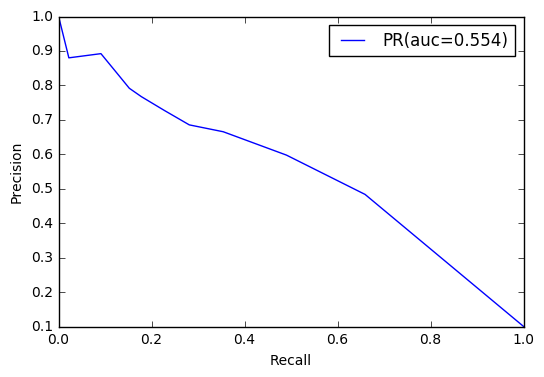

In [13]:
dfpred = dftest.copy()
dfpred.transaction = 0.0
dfpred = predict_by_receiver_similiarity(train_csr, dfpred)
print("Number of None zero values: %d" % (dfpred.transaction != 0).sum())
from utils import plot_precision_recall
plot_precision_recall(dftest.transaction, dfpred.transaction)

[0/1000]Working on sender: 1


/Users/wenjie/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in divide
/Users/wenjie/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in divide


Number of None zero values: 2
Plot Precision-Recall Curve


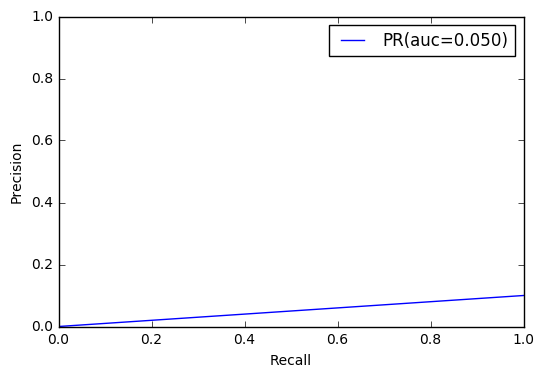

In [7]:
dfpred = dftest.copy()
dfpred.transaction = 0.0
dfpred = predict_by_sender_similarity(train_csr, dfpred)
print("Number of None zero values: %d" % (dfpred.transaction != 0).sum())
from utils import plot_precision_recall
plot_precision_recall(dftest.transaction, dfpred.transaction)

Label(0) -- size: 9000
Label(1) -- size: 1000


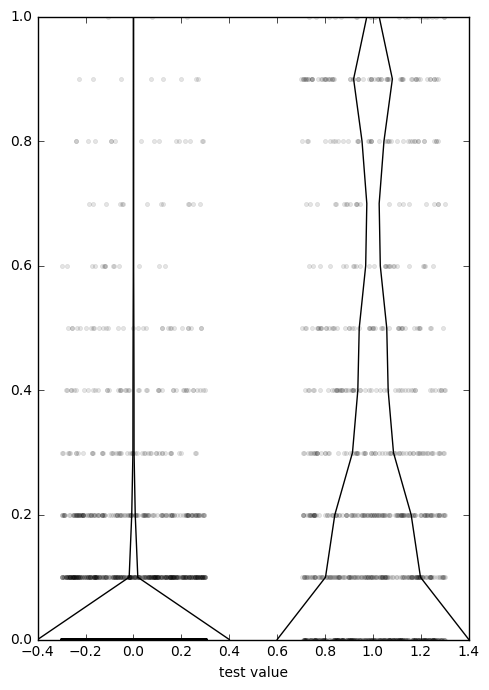

Area under the ROC curve : 0.799994


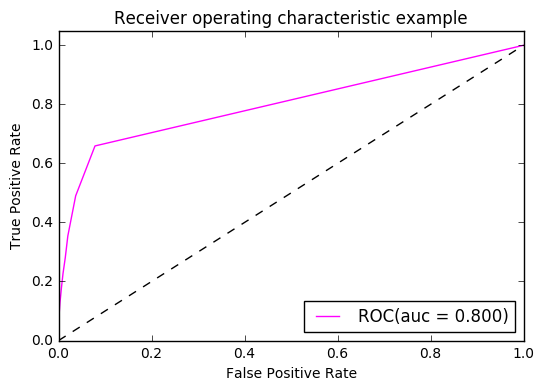

In [14]:
from __future__ import division
import matplotlib.pyplot as plt
#plt.hist(dfpred.transaction)
from utils import plot_roc_curve

def plot_voilin_curve(y_true, y_pred, figname=None):
    plt.figure(figsize=(5, 7))
    bins = np.arange(0, 1.2, 0.1)
    for _label in [0, 1]:
        array = []
        for idx, v in enumerate(y_true):
            if np.isclose(v,  _label):
                array.append(y_pred[idx])
        print("Label(%d) -- size: %d" % (_label, len(array)))
        values, edge = np.histogram(array, bins=bins)
        #print("values 0:", values)
        values = values / np.max(values) * 0.4
        #plt.figure()
        #plt.plot(edge[:-1], values)
        #ax = plt.gca()
        #ax.set_xscale('log')
        #print("values:", values)
        #print("edge: %s" % edge)
        plt.plot(_label+values, edge[:-1], "k-")
        plt.plot(_label-values, edge[:-1], "k-")

    y_new = np.array(y_true)
    y_new = y_true + np.random.uniform(low=-0.3, high=0.3, size=y_new.shape)

    plt.plot(y_new, y_pred, 'k.', alpha=0.1)
    #ax = plt.gca()
    #ax.set_yscale('log')
    #ax.set_ylim([1e-25, 1])
    #ax.set_xticks([0, 1])
    plt.xlabel("probability")
    plt.xlabel("test value")
    plt.tight_layout()

    if figname is None:
        plt.show()
    else:
        plt.savefig(figname)

plot_voilin_curve(dftest.transaction, dfpred.transaction)
plot_roc_curve(dftest.transaction, dfpred.transaction)

Plot Precision-Recall Curve


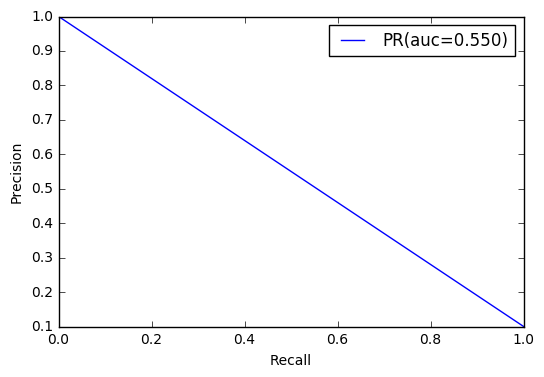

In [62]:
plot_precision_recall(dftest.transaction, np.zeros(len(dftest.transaction)))

In [46]:
train_csr[0, :] + train_csr[1, :]

<1x444075 sparse matrix of type '<type 'numpy.float64'>'
	with 16755 stored elements in Compressed Sparse Row format>

In [63]:
dftest.sort(columns="sender", inplace=True)

/Users/wenjie/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [62]:
d = dftest[dftest["sender"] == 3]
d.index

Int64Index([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27], dtype='int64')

In [67]:
train_csr[0, :] / 3

<1x444075 sparse matrix of type '<type 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>

In [69]:
dfpred = dftest.copy()

In [71]:
dfpred.transaction = 0

In [104]:
print dftest.loc[0].sender
print dftest.loc[0].receiver

1
16


In [100]:
len(dftest)

10000

In [149]:
dfpred

,sender,receiver,transaction
0,1,16,0.0
1,1,66,0.0
2,1,12458,0.0
3,1,22506,0.0
4,1,29176,0.0
5,1,38898,0.0
6,1,99687,0.0
7,1,244013,0.0
8,1,246667,0.0
9,1,330731,0.0


In [29]:
def sort_receiver_by_similarity(train_csr, receiver_id):
    dists = (train_csr[:, receiver_id].transpose()).dot(train_csr).toarray()[0]
    dist_info = [(idx, d) for (idx, d) in enumerate(dists)]
    dist_info = sorted(dist_info, key=lambda x: x[1], reverse=True)
    loc_info = [x[0] for x in dist_info]
    return loc_info


def average_top_k_reciver(train_csr, loc_info):
    vsum = train_csr[loc_info[0], :]
    for i in range(1, len(loc_info)):
        vsum += train_csr[loc_info[i], :]
        
    vsum = vsum / len(loc_info)
    #print type(vsum)
    #print vsum
    return vsum

In [31]:
sort_receiver_by_similarity(train_csr, receiver_id=0)

[0,
 4,
 19,
 24,
 36,
 62,
 63,
 64,
 71,
 74,
 76,
 80,
 85,
 103,
 105,
 117,
 118,
 129,
 130,
 134,
 151,
 189,
 196,
 200,
 231,
 279,
 301,
 336,
 365,
 1006,
 1655,
 2493,
 2578,
 2833,
 2928,
 3321,
 3450,
 3458,
 3665,
 4064,
 4923,
 5818,
 5874,
 6392,
 6495,
 7412,
 11412,
 11844,
 16446,
 22526,
 24404,
 24537,
 25030,
 25548,
 32694,
 34681,
 39386,
 41797,
 54508,
 55383,
 60300,
 66446,
 75662,
 95573,
 95574,
 139430,
 18,
 23,
 73,
 81,
 106,
 437,
 480,
 988,
 1246,
 1328,
 1429,
 1495,
 1711,
 1716,
 1958,
 2040,
 2417,
 2506,
 2678,
 2890,
 3149,
 3586,
 3972,
 4001,
 4673,
 4722,
 5476,
 6416,
 7034,
 7735,
 8302,
 8335,
 8628,
 8632,
 8934,
 9287,
 9745,
 10143,
 11292,
 11413,
 13742,
 14272,
 14366,
 15067,
 15191,
 17519,
 19149,
 19695,
 22009,
 22014,
 23212,
 24474,
 25312,
 27058,
 27328,
 37335,
 37695,
 38334,
 51857,
 54057,
 54182,
 55230,
 58304,
 60234,
 61452,
 62090,
 69010,
 70062,
 72596,
 72953,
 73337,
 85029,
 91132,
 91918,
 95026,
 99010,
 9

In [33]:
train_csr.transpose()

<444075x444075 sparse matrix of type '<type 'numpy.float64'>'
	with 3348026 stored elements in Compressed Sparse Column format>

In [67]:
print type(train_csr.sum(axis=0))

<class 'numpy.matrixlib.defmatrix.matrix'>


In [71]:
d = train_csr.sum(axis=0)
d = np.array(d)

In [73]:
a = np.array([1, 2, 3])
b = np.array([1, 2, 2])
a / b

array([ 1. ,  1. ,  1.5])

In [8]:
for i in range(train_csr.shape[])

<444075x444075 sparse matrix of type '<type 'numpy.float64'>'
	with 3348026 stored elements in Compressed Sparse Row format>

In [11]:
train_csr - train_csr[0, :]

ValueError: inconsistent shapes